In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [51]:
import importlib
import ids_common
importlib.reload(ids_common)

SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

SEED = 42


In [38]:
df_orig = pd.read_csv('./sampled_data/sample_1/clean_ml_sample_balanced_2_class.csv', low_memory=False)

In [39]:
df_train, df_test = ids_common.ds_split(df_orig, seed=42)

dataset = {}
dataset['2_class'] = {
    'train': ids_common.make_2_class(df_train),
    'test': ids_common.make_2_class(df_test)
}

dataset['14_class'] = {
    'train':ids_common.make_14_class(df_train),
    'test':ids_common.make_14_class(df_test)
}

dataset['15_class'] = {
    'train':ids_common.make_15_class(df_train),
    'test':ids_common.make_15_class(df_test)
}


def get_data(class_type, set_type):
    X, y = dataset[class_type][set_type]
    return X, y

In [40]:
X_train, y_train = get_data('15_class', 'train')
X_test, y_test = get_data('15_class', 'test')

print(np.unique(y_train, return_counts=True))

le = LabelEncoder()
y_train = le.fit_transform(y_train)

print(np.unique(y_train, return_counts=True))

y_train = le.inverse_transform(y_train)
print(np.unique(y_train, return_counts=True))


(array(['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
       'MITM', 'Normal', 'OS_Fingerprinting', 'Password', 'Port_Scanning',
       'Ransomware', 'SQL_injection', 'Uploading',
       'Vulnerability_scanner', 'XSS'], dtype=object), array([ 8000,  8000,  8000,  8000,  8000,   286, 96178,   579,  8000,
        8000,  7313,  8000,  8000,  8000,  8000], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([ 8000,  8000,  8000,  8000,  8000,   286, 96178,   579,  8000,
        8000,  7313,  8000,  8000,  8000,  8000], dtype=int64))
(array(['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
       'MITM', 'Normal', 'OS_Fingerprinting', 'Password', 'Port_Scanning',
       'Ransomware', 'SQL_injection', 'Uploading',
       'Vulnerability_scanner', 'XSS'], dtype=object), array([ 8000,  8000,  8000,  8000,  8000,   286, 96178,   579,  8000,
        8000,  7313,  8000,  8000,  8000,  8000], dtype=int64))


In [58]:
def make_classifier(name, cls):
    X_train, y_train = get_data(name, 'train')
    X_test, y_test = get_data(name, 'test')

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    cls.fit(X_train, y_train)

    y_train_predict = cls.predict(X_train)
    y_test_predict = cls.predict(X_test)

    print(f'{cls.__class__.__name__}:')
    print(f'Train score: {cls.score(X_train, y_train)}')
    print(f'Test score:  {cls.score(X_test, y_test)}')

    ids_common.report(y_train, y_train_predict, y_test, y_test_predict, le)
    ids_common.plot_cm(y_test, y_test_predict, le)

    return cls, le

DecisionTreeClassifier:
Train score: 0.966447628355757
Test score:  0.9647951757122063
TRAIN:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     96178
           1       1.00      0.93      0.97     96178

    accuracy                           0.97    192356
   macro avg       0.97      0.97      0.97    192356
weighted avg       0.97      0.97      0.97    192356

TEST:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     24045
           1       1.00      0.93      0.96     24045

    accuracy                           0.96     48090
   macro avg       0.97      0.96      0.96     48090
weighted avg       0.97      0.96      0.96     48090



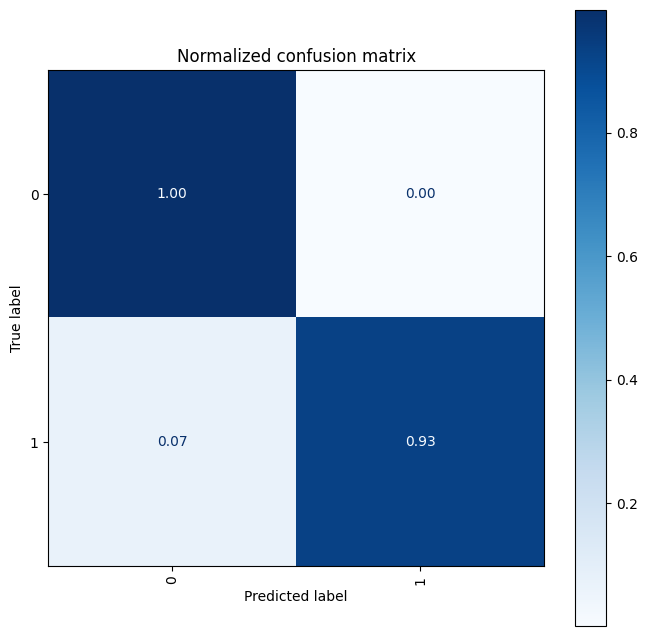

In [59]:
class_2_dt, le_2 = make_classifier( 
        '2_class',
        DecisionTreeClassifier(
                **{'criterion': 'entropy', 'max_depth': 16}, random_state=SEED),
)

XGBClassifier:
Train score: 0.9500197550375346
Test score:  0.9229361613641089
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.98      8000
            DDoS_HTTP       0.95      0.94      0.94      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
    OS_Fingerprinting       1.00      0.82      0.90       579
             Password       0.85      0.95      0.90      8000
        Port_Scanning       0.87      1.00      0.93      8000
           Ransomware       1.00      0.94      0.97      7313
        SQL_injection       0.88      0.91      0.90      8000
            Uploading       0.94      0.81      0.87      8000
Vulnerability_scanner       1.00      0.97      0.99      8000
                  XSS       0.9

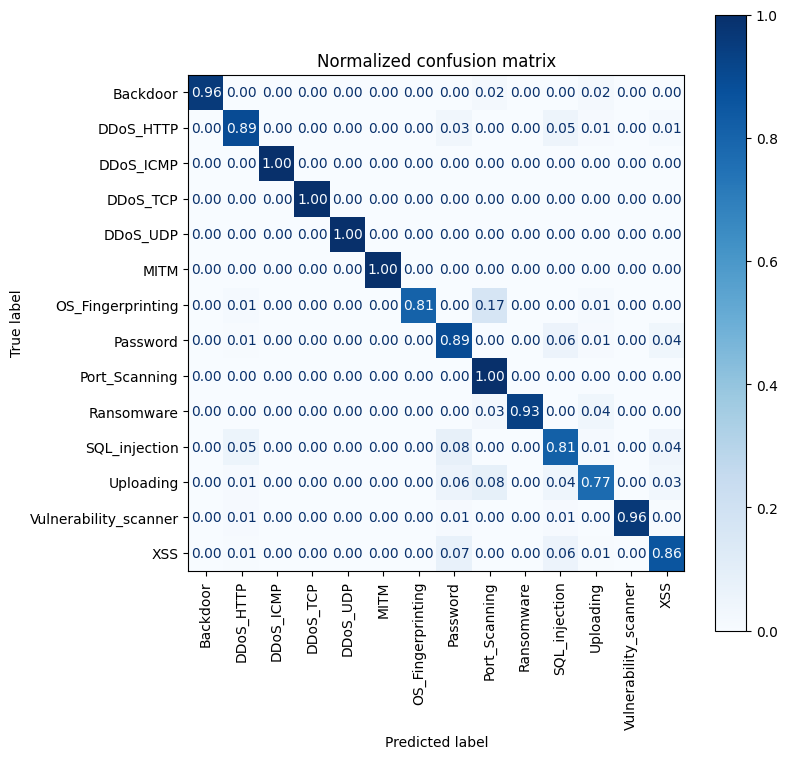

In [60]:
class_14_xgb, le_14 = make_classifier( 
        '14_class',
        xgb.XGBClassifier(objective="multi:softprob", random_state=SEED)
)

XGBClassifier:
Train score: 0.9566948782465845
Test score:  0.9526096901642753
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.98      8000
            DDoS_HTTP       0.97      0.92      0.94      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
               Normal       0.94      1.00      0.97     96178
    OS_Fingerprinting       1.00      0.83      0.91       579
             Password       1.00      0.80      0.89      8000
        Port_Scanning       0.87      1.00      0.93      8000
           Ransomware       1.00      0.94      0.97      7313
        SQL_injection       0.98      0.78      0.87      8000
            Uploading       0.95      0.77      0.85      8000
Vulnerability_scanner       1.0

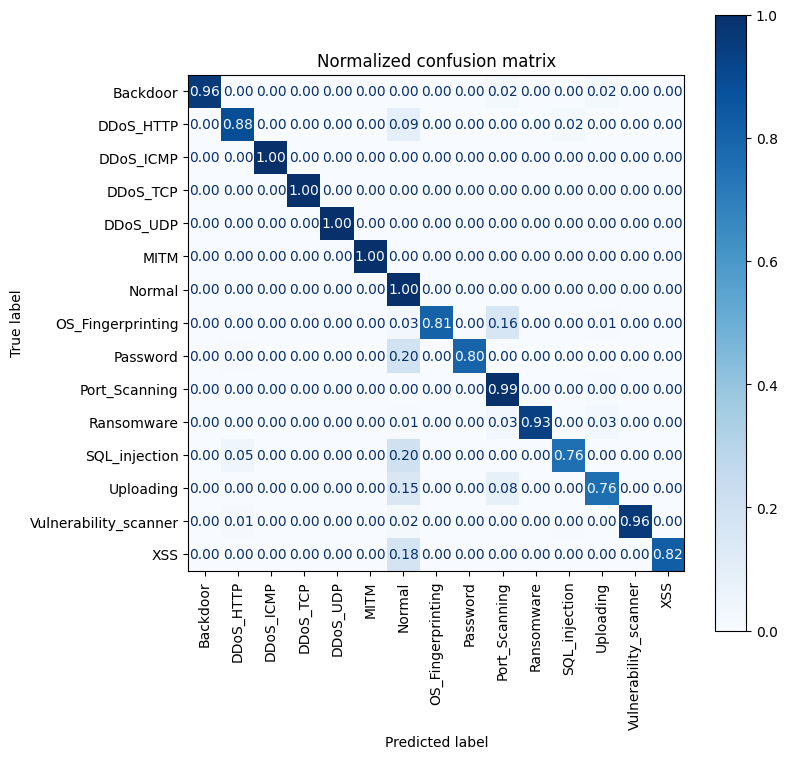

In [61]:
class_15_xgb, le_15 = make_classifier( 
        '15_class',
        xgb.XGBClassifier(objective="multi:softprob", random_state=SEED)
)

In [63]:
def eval_cascade(detector, classifier):

    _, y_class_2_test = get_data('2_class', 'test')
    X_test, y_class_15_test = get_data('15_class', 'test')

    # y_class_2_test = df_test[ids_common.target_label_2_class]
    # y_class_15_test = df_test[ids_common.target_label_15_class]

    # X_test = df_test.drop([ids_common.target_label_2_class, 
    #                 ids_common.target_label_15_class], 
    #                 axis=1, inplace=False)


    y_class_2_predict = detector.predict(X_test)

    ds_class_14 = df_test[y_class_2_predict==1]
    X_class_14 = ds_class_14.drop(
                    [ids_common.target_label_2_class, 
                    ids_common.target_label_15_class], 
                    axis=1, inplace=False)

    y_class_14_predict = classifier.predict(X_class_14)

    print(y_class_14_predict[:10])

    y_class_15_predict = pd.Series(y_class_2_predict, index=X_test.index.copy())
    y_class_15_predict = y_class_15_predict.map(lambda x: 'Normal' if x==0 else 'Attack')
    y_class_15_predict.loc[X_class_14.index] = le_14.inverse_transform(y_class_14_predict)

    print('DETECTION:')
    print(classification_report(y_class_2_test, y_class_2_predict))
    ids_common.plot_cm(y_class_2_test, y_class_2_predict)

    print('CLASSIFICATION:')
    print(classification_report(y_class_15_test, y_class_15_predict))
    ids_common.plot_cm(y_class_15_test, y_class_15_predict)

[11 13  8 10  0 13  8 11  4  0]
DETECTION:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     24045
           1       1.00      0.93      0.96     24045

    accuracy                           0.96     48090
   macro avg       0.97      0.96      0.96     48090
weighted avg       0.97      0.96      0.96     48090



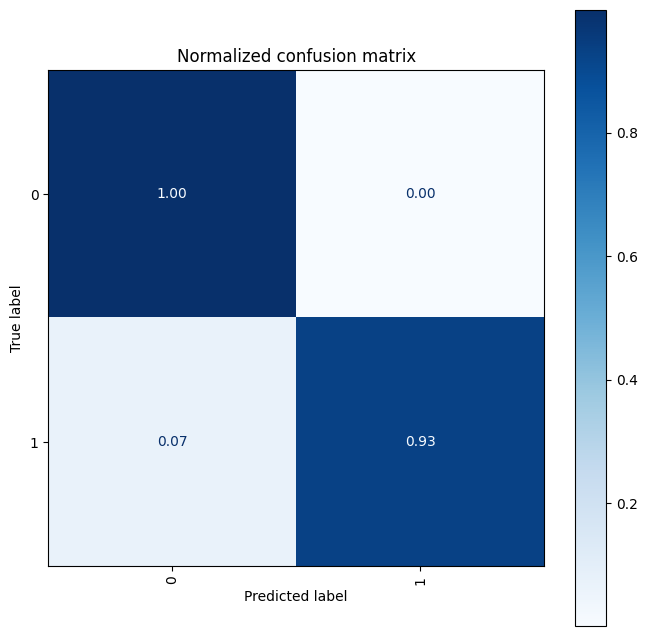

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.96      0.98      2000
            DDoS_HTTP       0.93      0.88      0.91      2000
            DDoS_ICMP       1.00      1.00      1.00      2000
             DDoS_TCP       1.00      1.00      1.00      2000
             DDoS_UDP       1.00      1.00      1.00      2000
                 MITM       1.00      1.00      1.00        72
               Normal       0.93      1.00      0.97     24045
    OS_Fingerprinting       0.99      0.81      0.89       145
             Password       0.99      0.80      0.89      2000
        Port_Scanning       0.88      1.00      0.93      2000
           Ransomware       1.00      0.93      0.96      1828
        SQL_injection       0.95      0.76      0.84      2000
            Uploading       0.94      0.76      0.84      2000
Vulnerability_scanner       0.99      0.96      0.98      2000
                  XSS       1.00      

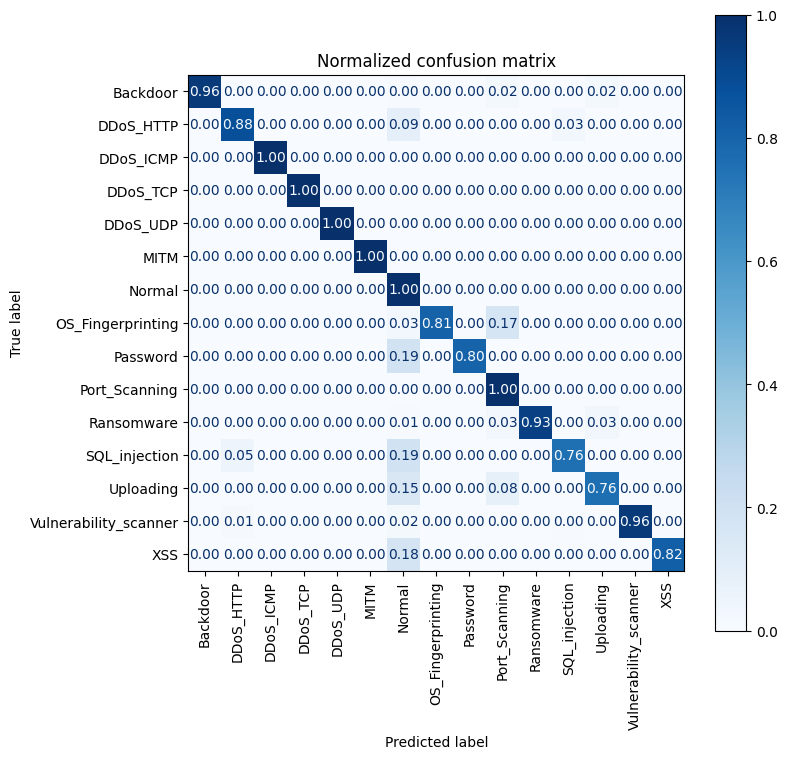

In [64]:
eval_cascade(detector=class_2_dt, classifier=class_14_xgb)

In [68]:
X_test, _ = get_data('15_class', 'test')

class_15_time = []
class_15_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    # print(row)
    # class_15_predicts.append(class_15_xgb.predict(pd.DataFrame(row).T))
    class_15_predicts.append(class_15_xgb.predict(row.to_numpy().reshape(1, -1)))

    class_15_time.append(time.time() - t)

    # print(class_15_predicts, class_15_time)

print(class_15_time[:10])

[0.0009999275207519531, 0.0, 0.0009996891021728516, 0.0, 0.0009999275207519531, 0.0, 0.0010001659393310547, 0.0, 0.0010023117065429688, 0.0]


In [74]:
X_test, _ = get_data('15_class', 'test')

class_casdade_time = []
class_cascade_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    record = row.to_numpy().reshape(1, -1)
    detection = class_2_dt.predict(record)

    if detection == 1:
        class_cascade_predicts.append(class_14_xgb.predict(record))
    else:
        class_cascade_predicts.append(detection)
    
    class_casdade_time.append(time.time() - t)

print(class_casdade_time[:10])

[0.0009813308715820312, 0.0009744167327880859, 0.001001119613647461, 0.0, 0.0, 0.001262664794921875, 0.0, 0.0, 0.0, 0.0010051727294921875]


In [75]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()

X_train, y_train = get_data('15_class', 'train')
dummy.fit(X_train, y_train)

X_test, _ = get_data('15_class', 'test')

dummy_time = []
dummy_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    
    dummy_predicts.append(dummy.predict(row.to_numpy().reshape(1, -1)))

    dummy_time.append(time.time() - t)


print(dummy_time[:10])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [76]:
def stats(tt):
    print(f'   min: {np.min(tt):0.5f}')
    print(f'   max: {np.max(tt):0.5f}')
    print(f'  mean: {np.mean(tt):0.5f}')
    print(f'median: {np.median(tt):0.5f}')
    print(f'   std: {np.std(tt):0.5f}')
    print(f' total: {np.sum(tt):0.5f}')

In [77]:
print('Classification 15:')
stats(class_15_time)
print('-'*80)

print('Classification cascade:')
stats(class_casdade_time)

print('-'*80)

print('Classification dummy:')
stats(dummy_time)

Classification 15:
   min: 0.00000
   max: 0.01301
  mean: 0.00042
median: 0.00000
   std: 0.00050
 total: 20.36096
--------------------------------------------------------------------------------
Classification cascade:
   min: 0.00000
   max: 0.01356
  mean: 0.00028
median: 0.00000
   std: 0.00046
 total: 13.30197
--------------------------------------------------------------------------------
Classification dummy:
   min: 0.00000
   max: 0.00154
  mean: 0.00001
median: 0.00000
   std: 0.00010
 total: 0.49464


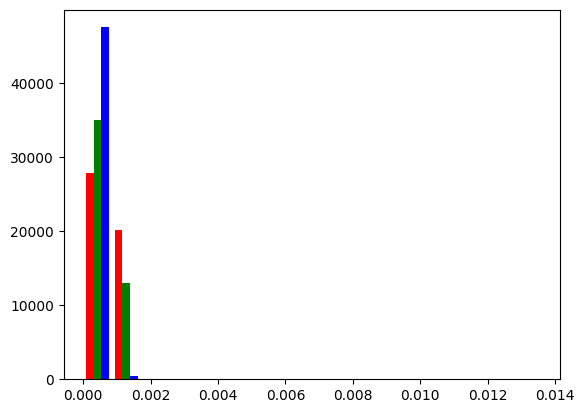

In [80]:
n_bins = 16
colors = ['red', 'green', 'blue']
x = [class_15_time, class_casdade_time, dummy_time]
names = ['class_15', 'cascade', 'dummy']
# Generate two normal distributions
plt.hist(x, n_bins, color=colors, label=names)
# plt.xscale('log')
plt.show()

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

models = [
    DecisionTreeClassifier(
        **{'criterion': 'entropy', 'max_depth': 16}, random_state=SEED),
    RandomForestClassifier(
        **{'criterion': 'entropy', 'max_depth': 128, 'max_features': 'log2', 'n_estimators': 100},random_state=SEED),
    LogisticRegression(
        **{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}, max_iter=10000, random_state=SEED),
    KNeighborsClassifier(5),
    QuadraticDiscriminantAnalysis(),
    AdaBoostClassifier(algorithm="SAMME", random_state=SEED),
    xgb.XGBClassifier(objective="multi:softprob", random_state=SEED)

]

DecisionTreeClassifier:
Train score: 0.9287986857701346
Test score:  0.9199833645248492
TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8000
           1       0.94      0.91      0.93      8000
           2       1.00      1.00      1.00      8000
           3       1.00      1.00      1.00      8000
           4       1.00      1.00      1.00      8000
           5       1.00      1.00      1.00       286
           6       0.99      0.81      0.89       579
           7       0.67      0.97      0.79      8000
           8       0.87      1.00      0.93      8000
           9       1.00      0.94      0.97      7313
          10       0.97      0.77      0.86      8000
          11       0.92      0.78      0.84      8000
          12       1.00      0.97      0.98      8000
          13       0.91      0.85      0.88      8000

    accuracy                           0.93     96178
   macro avg       0.95      0.93      

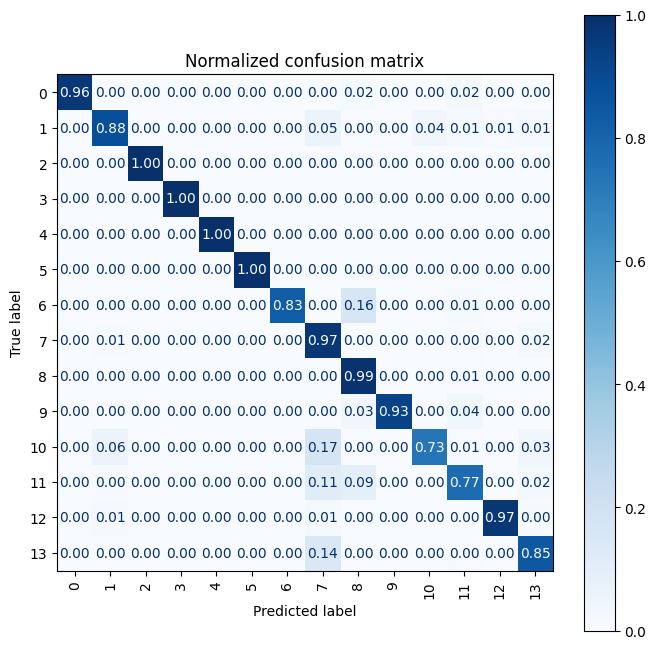

################################################################################
RandomForestClassifier:
Train score: 0.9999896026118239
Test score:  0.9157829070492826
TRAIN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8000
           1       1.00      1.00      1.00      8000
           2       1.00      1.00      1.00      8000
           3       1.00      1.00      1.00      8000
           4       1.00      1.00      1.00      8000
           5       1.00      1.00      1.00       286
           6       1.00      1.00      1.00       579
           7       1.00      1.00      1.00      8000
           8       1.00      1.00      1.00      8000
           9       1.00      1.00      1.00      7313
          10       1.00      1.00      1.00      8000
          11       1.00      1.00      1.00      8000
          12       1.00      1.00      1.00      8000
          13       1.00      1.00      1.00      8000

    accuracy

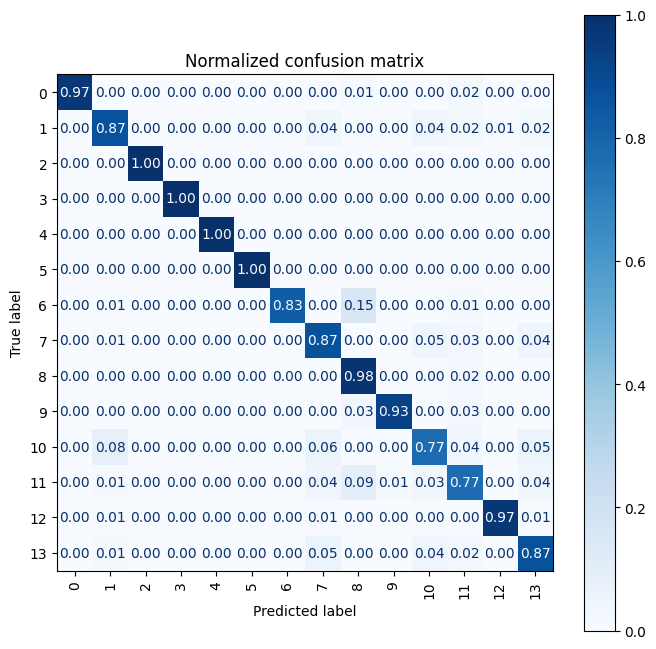

################################################################################
LogisticRegression:
Train score: 0.3289525671151407
Test score:  0.3271366188396756
TRAIN:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44      8000
           1       0.00      0.00      0.00      8000
           2       0.94      1.00      0.97      8000
           3       0.53      0.57      0.55      8000
           4       1.00      1.00      1.00      8000
           5       1.00      0.91      0.95       286
           6       0.00      0.00      0.00       579
           7       0.11      0.06      0.08      8000
           8       0.03      0.00      0.01      8000
           9       0.00      0.00      0.00      7313
          10       0.00      0.00      0.00      8000
          11       0.15      0.02      0.03      8000
          12       0.14      0.82      0.24      8000
          13       0.00      0.00      0.00      8000

    accuracy    

c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pro17\anaconda3\env

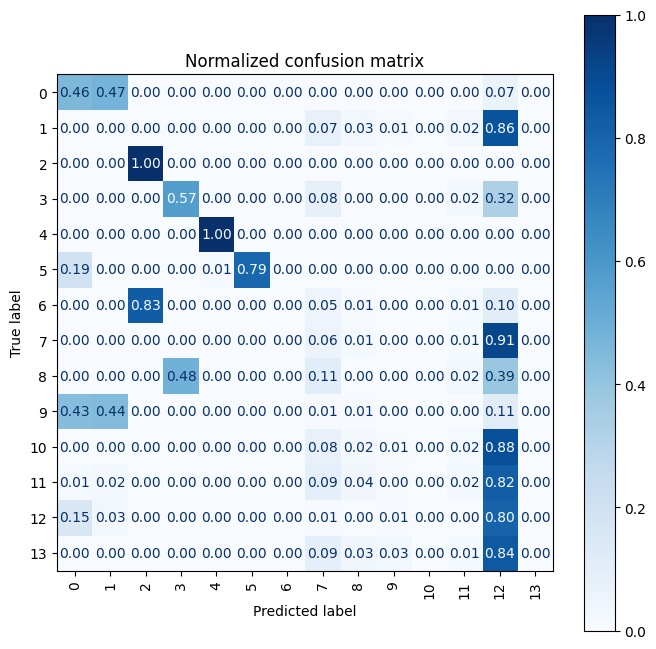

################################################################################
KNeighborsClassifier:
Train score: 0.7442554430327102
Test score:  0.6104803493449782
TRAIN:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8000
           1       0.54      0.72      0.61      8000
           2       1.00      0.99      1.00      8000
           3       0.61      0.57      0.59      8000
           4       1.00      1.00      1.00      8000
           5       1.00      1.00      1.00       286
           6       0.87      0.79      0.83       579
           7       0.52      0.39      0.45      8000
           8       0.61      0.47      0.53      8000
           9       1.00      0.94      0.97      7313
          10       0.58      0.53      0.55      8000
          11       0.64      0.57      0.60      8000
          12       0.77      0.90      0.83      8000
          13       0.68      0.89      0.77      8000

    accuracy  

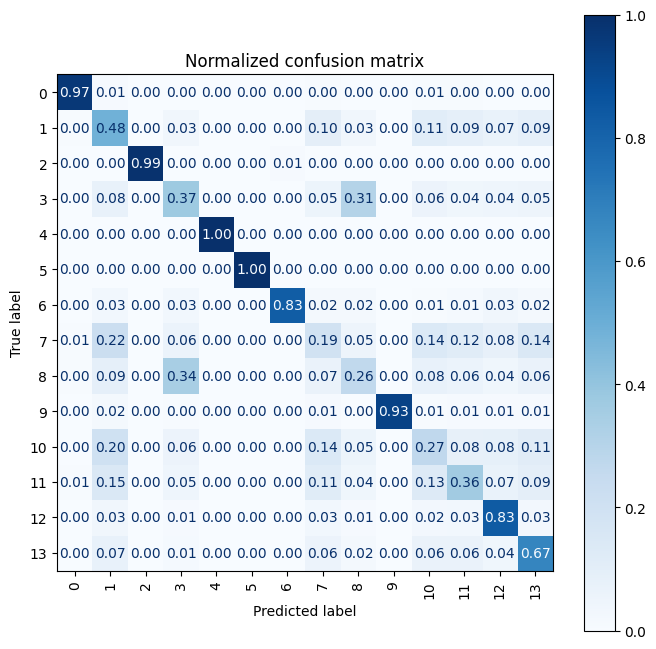

################################################################################


c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis:
Train score: 0.5242779013911706
Test score:  0.5219380328550635
TRAIN:
              precision    recall  f1-score   support

           0       0.26      0.96      0.40      8000
           1       0.66      0.00      0.00      8000
           2       0.95      1.00      0.97      8000
           3       0.73      0.89      0.80      8000
           4       1.00      1.00      1.00      8000
           5       1.00      1.00      1.00       286
           6       0.02      0.06      0.03       579
           7       0.59      0.22      0.32      8000
           8       0.78      0.63      0.69      8000
           9       0.21      0.26      0.23      7313
          10       0.34      0.49      0.40      8000
          11       0.36      0.06      0.10      8000
          12       1.00      0.74      0.85      8000
          13       0.96      0.03      0.06      8000

    accuracy                           0.52     96178
   macro avg       0.63      0.5

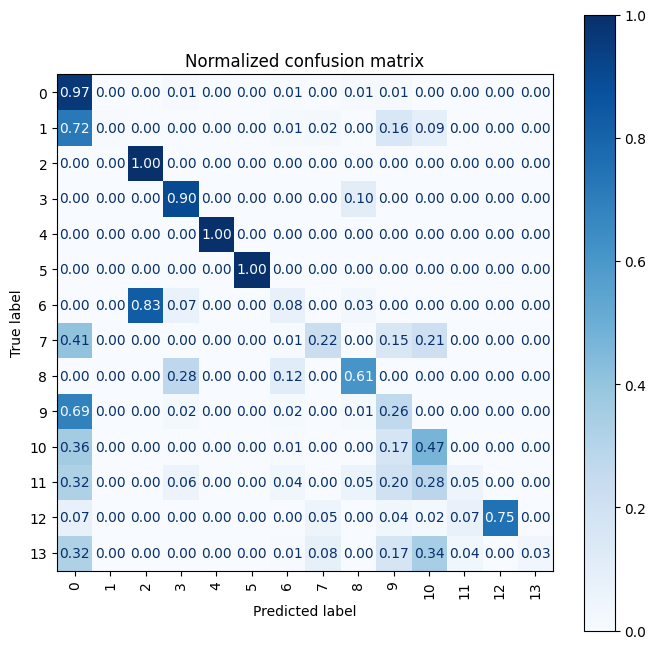

################################################################################
AdaBoostClassifier:
Train score: 0.4073904635155649
Test score:  0.40973175296319403
TRAIN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8000
           1       0.00      0.00      0.00      8000
           2       1.00      1.00      1.00      8000
           3       0.53      0.57      0.55      8000
           4       1.00      1.00      1.00      8000
           5       0.00      0.00      0.00       286
           6       0.00      0.00      0.00       579
           7       0.00      0.00      0.00      8000
           8       0.37      0.50      0.43      8000
           9       0.00      0.00      0.00      7313
          10       0.00      0.00      0.00      8000
          11       0.04      0.02      0.03      8000
          12       0.45      0.86      0.59      8000
          13       0.19      0.95      0.31      8000

    accuracy   

c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pro17\anaconda3\env

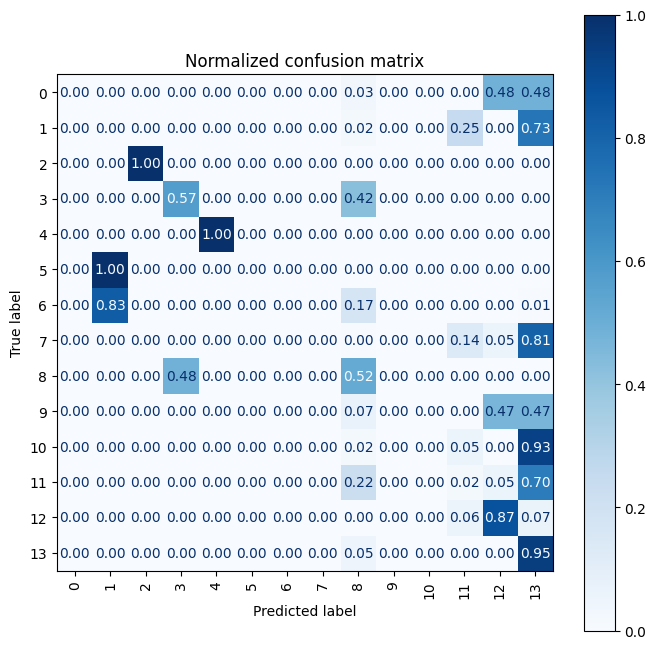

################################################################################
XGBClassifier:
Train score: 0.9504876375054586
Test score:  0.9218964441671865
TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8000
           1       0.95      0.94      0.94      8000
           2       1.00      1.00      1.00      8000
           3       1.00      1.00      1.00      8000
           4       1.00      1.00      1.00      8000
           5       1.00      1.00      1.00       286
           6       1.00      0.83      0.90       579
           7       0.85      0.95      0.90      8000
           8       0.87      1.00      0.93      8000
           9       1.00      0.95      0.97      7313
          10       0.89      0.90      0.90      8000
          11       0.94      0.81      0.87      8000
          12       1.00      0.97      0.99      8000
          13       0.93      0.93      0.93      8000

    accuracy         

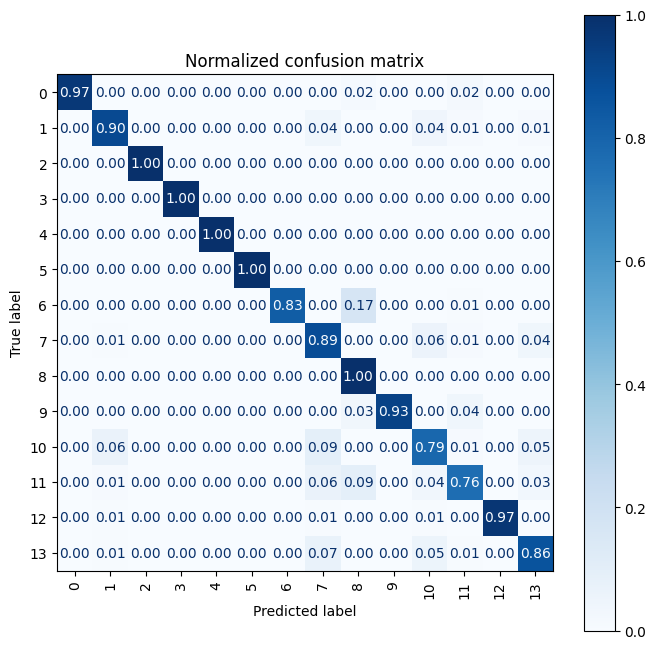

################################################################################


In [29]:
for cls in models:
    cls.fit(X_train, y_train)

    y_train_predict = cls.predict(X_train)
    y_test_predict = cls.predict(X_test)

    print(f'{cls.__class__.__name__}:')
    print(f'Train score: {cls.score(X_train, y_train)}')
    print(f'Test score:  {cls.score(X_test, y_test)}')

    ids_common.report(y_train, y_train_predict, y_test, y_test_predict)
    ids_common.plot_cm(y_test, y_test_predict)

    print('#'*80)

TRAIN:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    872958
           1       1.00      0.98      0.99    349230

    accuracy                           0.99   1222188
   macro avg       0.99      0.99      0.99   1222188
weighted avg       0.99      0.99      0.99   1222188

TEST:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    218240
           1       0.92      0.91      0.92     87308

    accuracy                           0.95    305548
   macro avg       0.94      0.94      0.94    305548
weighted avg       0.95      0.95      0.95    305548



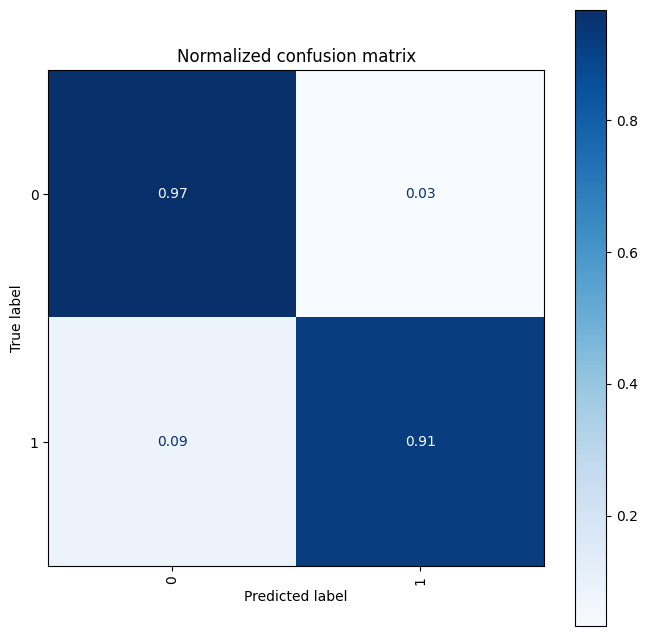

In [14]:
detector = DecisionTreeClassifier(random_state=SEED)

detector.fit(X_train_detection, y_train_detection)
y_train_detection_predict = detector.predict(X_train_detection)
y_test_detection_predict = detector.predict(X_test_detection)

report(y_train_detection, 
       y_train_detection_predict, 
       y_test_detection,
       y_test_detection_predict)

plot_cm(y_test_detection, y_test_detection_predict)


TRAIN:
                       precision    recall  f1-score   support

             Backdoor       0.99      1.00      1.00     15377
            DDoS_HTTP       0.96      1.00      0.98     31068
            DDoS_ICMP       1.00      1.00      1.00     43481
             DDoS_TCP       1.00      1.00      1.00     32040
             DDoS_UDP       1.00      1.00      1.00     77802
       Fingerprinting       0.97      0.98      0.98       545
                 MITM       1.00      1.00      1.00       229
             Password       0.99      0.99      0.99     31957
        Port_Scanning       1.00      1.00      1.00     12785
           Ransomware       0.99      0.99      0.99      6201
        SQL_injection       0.99      0.99      0.99     32529
            Uploading       1.00      0.96      0.98     23557
Vulnerability_scanner       1.00      1.00      1.00     32017
                  XSS       1.00      0.98      0.99      9642

             accuracy                         

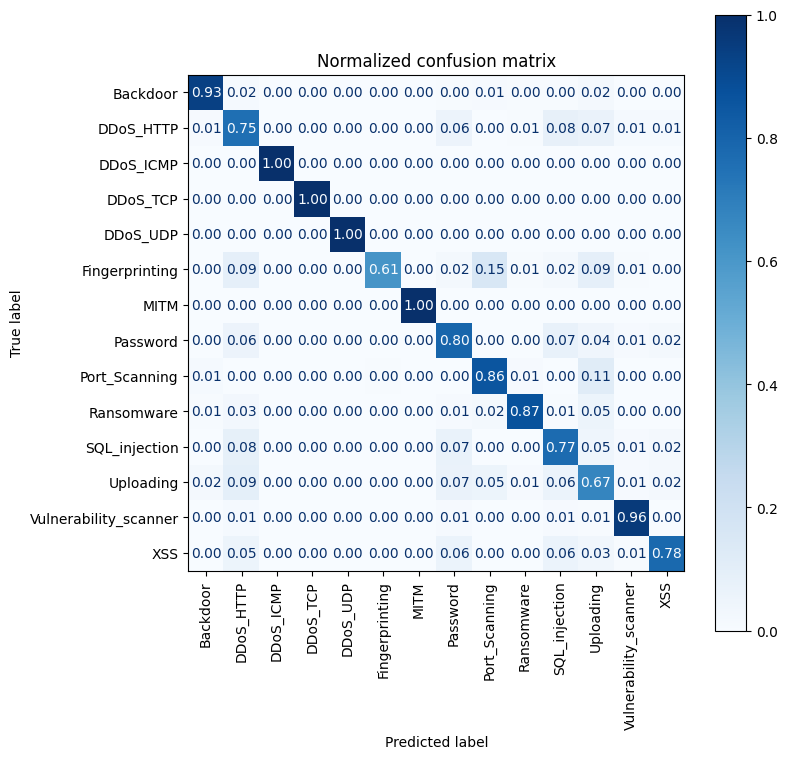

In [15]:
classifier = DecisionTreeClassifier(random_state=SEED)

classifier.fit(X_train_classification, y_train_classification)
y_train_classification_predict = classifier.predict(X_train_classification)
y_test_classification_predict = classifier.predict(X_test_classification)

report(y_train_classification, 
       y_train_classification_predict, 
       y_test_classification,
       y_test_classification_predict)

plot_cm(y_test_classification, y_test_classification_predict)

DETECTION:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    272800
           1       0.91      0.91      0.91    109135

    accuracy                           0.95    381935
   macro avg       0.94      0.94      0.94    381935
weighted avg       0.95      0.95      0.95    381935



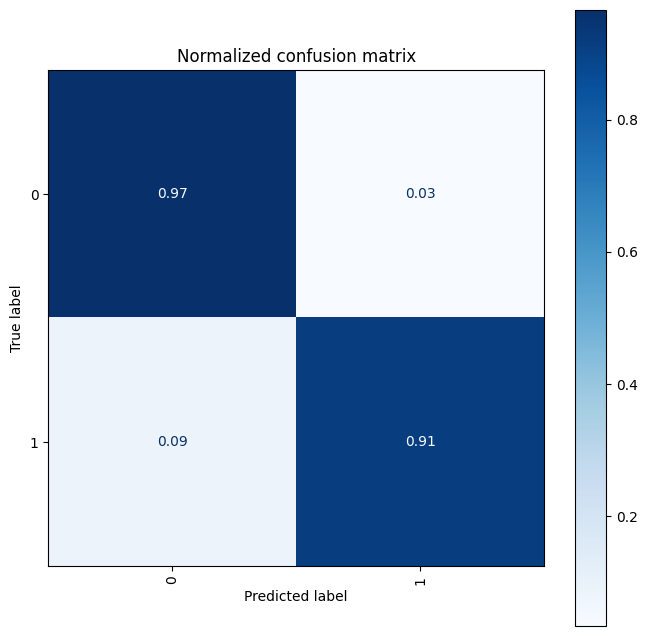

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       0.93      0.93      0.93      4805
            DDoS_HTTP       0.67      0.68      0.67      9709
            DDoS_ICMP       1.00      1.00      1.00     13588
             DDoS_TCP       1.00      1.00      1.00     10012
             DDoS_UDP       1.00      1.00      1.00     24314
       Fingerprinting       0.71      0.67      0.69       171
                 MITM       1.00      1.00      1.00        72
               Normal       0.97      0.97      0.97    272800
             Password       0.74      0.74      0.74      9987
        Port_Scanning       0.86      0.86      0.86      3995
           Ransomware       0.89      0.88      0.88      1938
        SQL_injection       0.72      0.72      0.72     10165
            Uploading       0.65      0.63      0.64      7361
Vulnerability_scanner       0.96      0.96      0.96     10005
                  XSS       0.76      

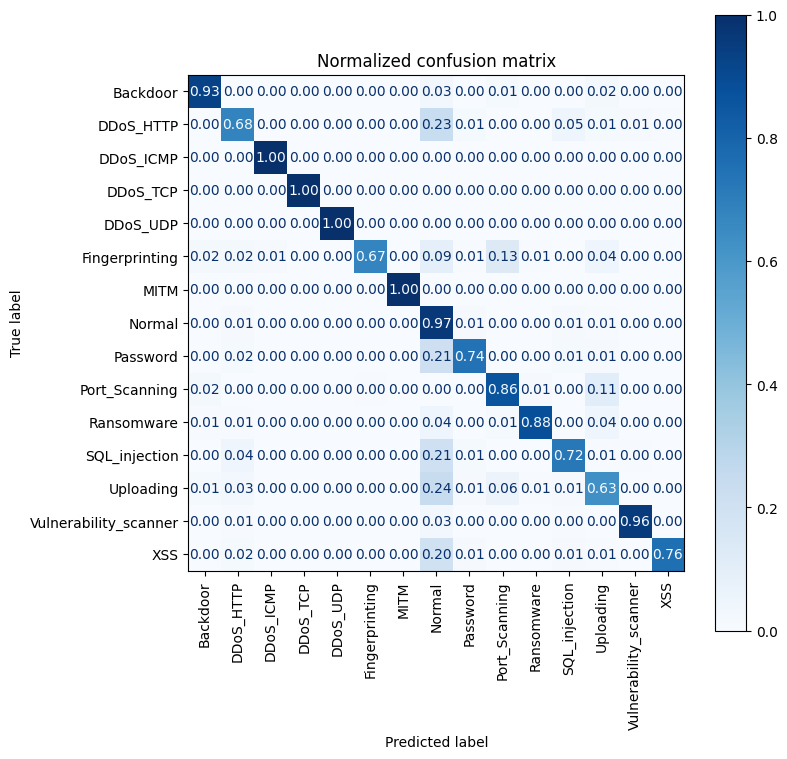

In [16]:
# combined detection with classification
y_global_label = df_test_global[target_label_2_class]
y_global_type = df_test_global[target_label_15_class]
X_global = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)


y_global_detection_predict = detector.predict(X_global)

ds_classification = df_test_global[y_global_detection_predict==1]
X_global_classification = ds_classification.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_classification_predict = classifier.predict(X_global_classification)


global_result = pd.Series(y_global_detection_predict, index=X_global.index.copy())
global_result = global_result.map(lambda x: 'Normal' if x==0 else 'Attack')
global_result.loc[X_global_classification.index] = y_global_classification_predict

print('DETECTION:')
print(classification_report(y_global_label, y_global_detection_predict))
plot_cm(y_global_label, y_global_detection_predict)

print('CLASSIFICATION:')
print(classification_report(y_global_type, global_result))
plot_cm(y_global_type, global_result)



In [ ]:
                     precision    recall  f1-score   support

             Backdoor       0.99      0.96      0.98      2000
            DDoS_HTTP       0.91      0.87      0.89      2000
            DDoS_ICMP       1.00      1.00      1.00      2000
             DDoS_TCP       1.00      1.00      1.00      2000
             DDoS_UDP       1.00      1.00      1.00      2000
                 MITM       1.00      1.00      1.00        72
               Normal       0.94      0.99      0.96     24045
    OS_Fingerprinting       0.95      0.81      0.87       145
             Password       0.93      0.81      0.87      2000
        Port_Scanning       0.88      0.97      0.93      2000
           Ransomware       0.98      0.94      0.96      1828
        SQL_injection       0.91      0.75      0.82      2000
            Uploading       0.88      0.76      0.81      2000
Vulnerability_scanner       0.99      0.96      0.97      2000
                  XSS       0.96      0.82      0.88      2000

             accuracy                           0.95     48090
            macro avg       0.96      0.91      0.93     48090
         weighted avg       0.95      0.95      0.94     48090

# XAI

In [17]:

sorted(zip(detector.feature_importances_.round(2),
           detector.feature_names_in_),
           reverse=True)[:10]

[(0.33, 'tcp.flags'),
 (0.31, 'tcp.seq'),
 (0.15, 'tcp.ack'),
 (0.09, 'tcp.checksum'),
 (0.08, 'tcp.len'),
 (0.03, 'tcp.ack_raw'),
 (0.01, 'udp.time_delta'),
 (0.01, 'mqtt.conflags'),
 (0.0, 'udp.stream'),
 (0.0, 'tcp.flags.ack')]

In [18]:
sorted(zip(classifier.feature_importances_.round(2),
           classifier.feature_names_in_),
           reverse=True)[:10]

[(0.25, 'tcp.ack'),
 (0.22, 'udp.stream'),
 (0.13, 'icmp.seq_le'),
 (0.09, 'tcp.seq'),
 (0.08, 'tcp.checksum'),
 (0.07, 'http.content_length'),
 (0.06, 'tcp.len'),
 (0.06, 'tcp.ack_raw'),
 (0.03, 'tcp.connection.rst'),
 (0.0, 'udp.time_delta')]

In [19]:
detector.get_n_leaves()

50667

In [20]:
# tree.plot_tree(detector, max_depth=4)

# drafts

In [21]:
# hard stop
raise AssertionError('drafts: stop execution')

AssertionError: drafts: stop execution

In [ ]:
# first try

# df_train_global, df_test_global = ds_split(df)

y_global_detection = df_test_global[target_label_2_class]
X_global_detection = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_detection_predict = detector.predict(X_global_detection)
print('DETECTION:')
print(classification_report(y_global_detection, y_global_detection_predict))
plot_cm(y_global_detection, y_global_detection_predict)

# np.unique(y_global_detection_predict, return_counts=True)
# (array([0, 1], dtype=int64), array([272875, 109060], dtype=int64))

ds_classification = df_test_global[y_global_detection_predict==1]

y_global_classification = ds_classification[target_label_15_class]
X_global_classification = ds_classification.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_classification_predict = classifier.predict(X_global_classification)

print('CLASSIFICATION:')
print(classification_report(y_global_classification, y_global_classification_predict))
plot_cm(y_global_classification, y_global_classification_predict)

# pd.Series([True, False, True, True, False, False, False, True]).values

In [ ]:
detected_attack_type = []

y_global_label = df_test_global[target_label_2_class]
y_global_type = df_test_global[target_label_15_class]
X_global = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

c = 0
for i in df_test_global.index:
    
   
    xx = X_global.loc[i].to_numpy().reshape(1, -1)
    y_detected = detector.predict(xx)[0]

    traffic_type = None
     
    if not y_detected:
        traffic_type = 'Normal'
    else:
        y_class_predicted = classifier.predict(xx)[0]
        traffic_type = y_class_predicted


    detected_attack_type.append(traffic_type)
    

    # print(traffic_type, y_global_label.loc[i], y_global_type.loc[i])
    
    # c += 1
    # if c > 10:
    #     break

print('ALL:')
print(classification_report(y_global_type, detected_attack_type))
plot_cm(y_global_type, detected_attack_type)

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1], dtype=int64)